# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt, log10
import torch
import torchvision
import numpy
import timm
import pandas
from copy import deepcopy
from cluster import train, confusion, execute, epochs, SelectedGPUs
from PIL import Image
from itertools import product

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8

FontLibrary.Fonts.GraphTitle.FontSize = 10

FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device(7)
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Распросранение излучения

In [5]:
N = 2048
apperture = 10.0E-3
wavelength = 500.0E-9
spatial_coherence = 200.0E-6
time_coherence = 10.0E-9
relaxation_time = 1.0E-6
samples = 40
focus = 300.0E-3
cols = 10
rows = 10
distance_range = torch.linspace(0, 10.0*focus, cols*rows)

In [6]:
image, _ = next(iter(Dataset("MNIST", 1, N, N, torch.complex64).test))
image = image.to(device)

incoherent = Incoherent(spatial_coherence, time_coherence, relaxation_time, samples, N, apperture)
encoder, decoder = incoherent.pair()
prepropagation = FurrierPropagation(N, apperture, wavelength, 1.0, 0.0, 2*focus, border_ratio=0.5)
propagation = FurrierPropagation(N, apperture, wavelength, 1.0, 0.0, distance_range[0], border_ratio=0.5)
lens = Lens(N, apperture, wavelength, 1.5, 0.0, 1.0, 0.0, focus)

model = CompositeModel(encoder, prepropagation, lens, propagation, decoder).to(device)

In [7]:
slices = torch.zeros((cols*rows, N, N))
with torch.no_grad():
    for i, distance in tqdm(enumerate(distance_range), total=cols*rows):
        propagation.distance = distance
        result = model.forward(image).abs().cpu().squeeze()
        slices[i] = result

  1%|▊                                                                                  | 1/100 [00:18<30:01, 18.19s/it]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


  2%|█▋                                                                                 | 2/100 [00:18<12:25,  7.60s/it]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


  4%|███▎                                                                               | 4/100 [00:18<04:11,  2.62s/it]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


  5%|████▏                                                                              | 5/100 [00:18<02:45,  1.74s/it]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


  7%|█████▊                                                                             | 7/100 [00:19<01:20,  1.15it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


  8%|██████▋                                                                            | 8/100 [00:19<00:59,  1.54it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 10%|████████▏                                                                         | 10/100 [00:19<00:35,  2.50it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 11%|█████████                                                                         | 11/100 [00:19<00:29,  3.03it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 13%|██████████▋                                                                       | 13/100 [00:20<00:21,  3.99it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 14%|███████████▍                                                                      | 14/100 [00:20<00:19,  4.39it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 16%|█████████████                                                                     | 16/100 [00:20<00:17,  4.93it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 17%|█████████████▉                                                                    | 17/100 [00:21<00:16,  5.12it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 19%|███████████████▌                                                                  | 19/100 [00:21<00:14,  5.44it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 20%|████████████████▍                                                                 | 20/100 [00:21<00:14,  5.51it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 22%|██████████████████                                                                | 22/100 [00:21<00:13,  5.59it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 23%|██████████████████▊                                                               | 23/100 [00:22<00:13,  5.58it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 25%|████████████████████▌                                                             | 25/100 [00:22<00:13,  5.62it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 26%|█████████████████████▎                                                            | 26/100 [00:22<00:13,  5.66it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 28%|██████████████████████▉                                                           | 28/100 [00:22<00:12,  5.65it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 29%|███████████████████████▊                                                          | 29/100 [00:23<00:12,  5.65it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 31%|█████████████████████████▍                                                        | 31/100 [00:23<00:12,  5.69it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 32%|██████████████████████████▏                                                       | 32/100 [00:23<00:11,  5.71it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 34%|███████████████████████████▉                                                      | 34/100 [00:24<00:11,  5.58it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 35%|████████████████████████████▋                                                     | 35/100 [00:24<00:11,  5.54it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 37%|██████████████████████████████▎                                                   | 37/100 [00:24<00:11,  5.61it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 38%|███████████████████████████████▏                                                  | 38/100 [00:24<00:10,  5.66it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 40%|████████████████████████████████▊                                                 | 40/100 [00:25<00:10,  5.64it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 41%|█████████████████████████████████▌                                                | 41/100 [00:25<00:10,  5.61it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 43%|███████████████████████████████████▎                                              | 43/100 [00:25<00:10,  5.63it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 44%|████████████████████████████████████                                              | 44/100 [00:25<00:09,  5.61it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 46%|█████████████████████████████████████▋                                            | 46/100 [00:26<00:09,  5.63it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 47%|██████████████████████████████████████▌                                           | 47/100 [00:26<00:09,  5.62it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 49%|████████████████████████████████████████▏                                         | 49/100 [00:26<00:08,  5.69it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 50%|█████████████████████████████████████████                                         | 50/100 [00:26<00:08,  5.70it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 52%|██████████████████████████████████████████▋                                       | 52/100 [00:27<00:08,  5.59it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 53%|███████████████████████████████████████████▍                                      | 53/100 [00:27<00:08,  5.64it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 55%|█████████████████████████████████████████████                                     | 55/100 [00:27<00:07,  5.69it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 56%|█████████████████████████████████████████████▉                                    | 56/100 [00:27<00:07,  5.65it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 58%|███████████████████████████████████████████████▌                                  | 58/100 [00:28<00:07,  5.58it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 59%|████████████████████████████████████████████████▍                                 | 59/100 [00:28<00:07,  5.59it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 61%|██████████████████████████████████████████████████                                | 61/100 [00:28<00:06,  5.63it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 62%|██████████████████████████████████████████████████▊                               | 62/100 [00:29<00:06,  5.61it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 64%|████████████████████████████████████████████████████▍                             | 64/100 [00:29<00:06,  5.64it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 65%|█████████████████████████████████████████████████████▎                            | 65/100 [00:29<00:06,  5.62it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 67%|██████████████████████████████████████████████████████▉                           | 67/100 [00:29<00:05,  5.64it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 68%|███████████████████████████████████████████████████████▊                          | 68/100 [00:30<00:05,  5.59it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [00:30<00:05,  5.50it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [00:30<00:05,  5.56it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [00:30<00:04,  5.66it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [00:31<00:04,  5.70it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [00:31<00:04,  5.75it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [00:31<00:04,  5.74it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 79%|████████████████████████████████████████████████████████████████▊                 | 79/100 [00:32<00:03,  5.73it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [00:32<00:03,  5.68it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [00:32<00:03,  5.70it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 83%|████████████████████████████████████████████████████████████████████              | 83/100 [00:32<00:02,  5.72it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 85%|█████████████████████████████████████████████████████████████████████▋            | 85/100 [00:33<00:02,  5.70it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [00:33<00:02,  5.71it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [00:33<00:02,  5.74it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 89%|████████████████████████████████████████████████████████████████████████▉         | 89/100 [00:33<00:01,  5.73it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 91%|██████████████████████████████████████████████████████████████████████████▌       | 91/100 [00:34<00:01,  5.68it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [00:34<00:01,  5.70it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [00:34<00:01,  5.70it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:34<00:00,  5.73it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:35<00:00,  5.67it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:35<00:00,  5.68it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s]

Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])
Начальный размер: torch.Size([1, 40, 2048, 2048])
После первого паддинга и преобразования Фурье: torch.Size([1, 40, 4096, 4096])
После обработки депадинга: torch.Size([1, 40, 2048, 2048])
После интерполяции: torch.Size([1, 40, 2048, 2048])


In [8]:
v_min = torch.min(slices).item()
v_max = torch.max(slices).item()

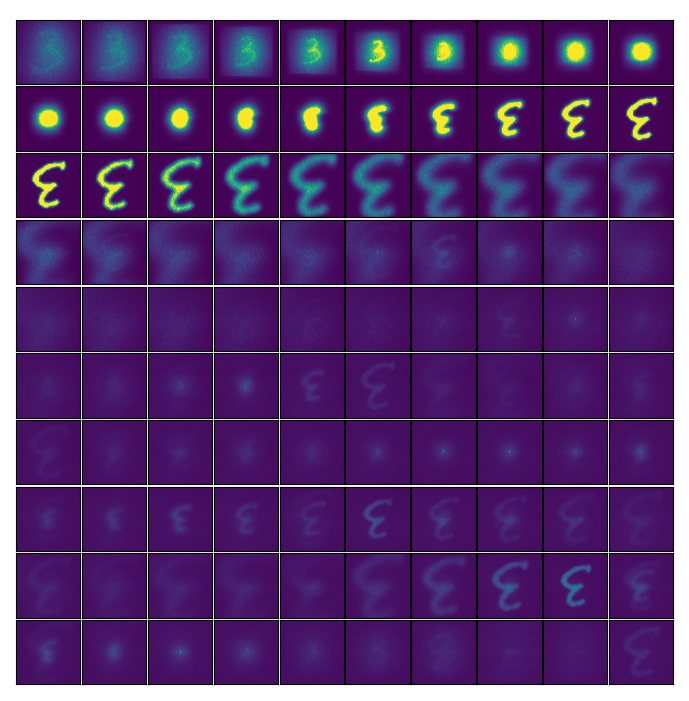

In [9]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

for (row, col), image in zip(product(range(rows), range(cols)), slices):
    axes = plot.axes.add(col, row)
    # axes.imshow(torch.log10(image + 1.0), aspect='auto', vmin=log10(v_min+1), vmax=log10(v_max+1))
    axes.imshow(image, aspect='auto', vmin=v_min, vmax=2.0)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)

plot.show()

In [10]:
integrals = torch.mean(slices, dim=(1,2))
integrals.shape

torch.Size([100])

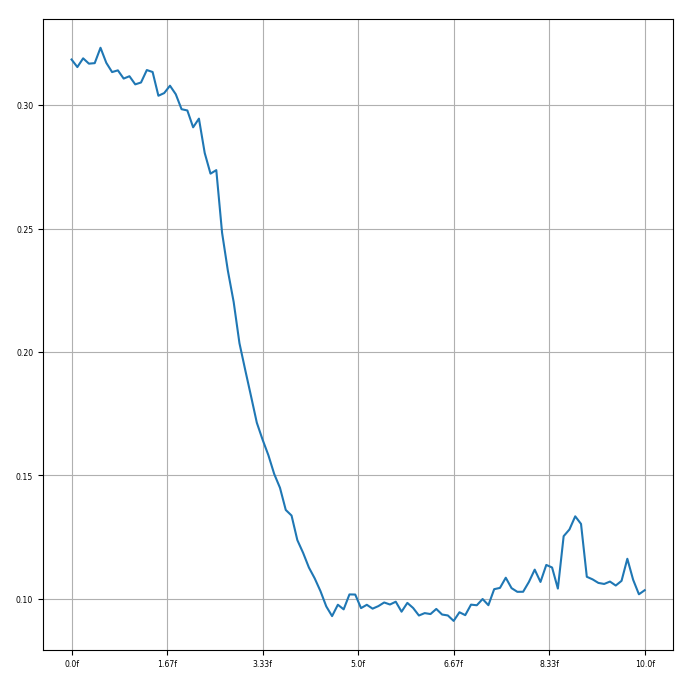

In [11]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

def formatter(x:float, index:int):
    ratio = x / focus
    return f"{round(ratio, 2)}f"

axes = plot.axes.add()
axes.grid(True)
axes.xaxis.set_major_formatter(formatter)
axes.plot(distance_range, integrals)

plot.show()